In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from fastai.callbacks import *
np.random.seed(0)

In [3]:
torch.cuda.set_device(1)

# Data import

In [4]:
IMG_PATH = DATA_PATH/'wine'

In [5]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


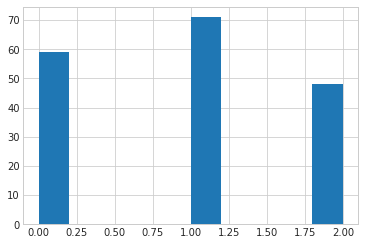

In [6]:
train_df.target.hist()

In [7]:
size = 224

In [8]:
train_df.head()

,image_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [9]:
data = ImageDataBunch.from_df(df=train_df, label_col='target', fn_col='image_name',
                              bs=16, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [10]:
data

ImageDataBunch;

Train: LabelList (143 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: ../data/wine/images;

Valid: LabelList (35 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,2,1,0,1
Path: ../data/wine/images;

Test: None

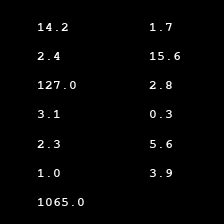

In [11]:
data.train_ds[0][0]

# Model training

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, lin_ftrs=[], bn_final=False, ps=[0])

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


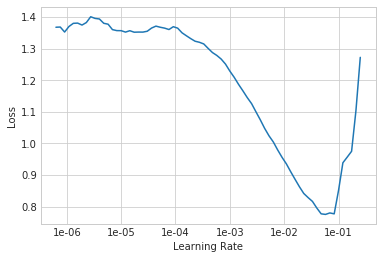

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.338834,1.139841,0.257143,00:01
1,1.202940,1.715476,0.171429,00:01
2,0.947860,1.798449,0.285714,00:01
3,0.735873,1.421654,0.400000,00:01
4,0.578586,1.044487,0.542857,00:01
5,0.470466,0.823244,0.657143,00:01
6,0.383727,0.571708,0.742857,00:01
7,0.322346,0.441998,0.828571,00:01
8,0.280104,0.403628,0.857143,00:01
9,0.239116,0.394848,0.828571,00:01


In [19]:
learn.save('stage-1')

In [20]:
learn.unfreeze()

In [28]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


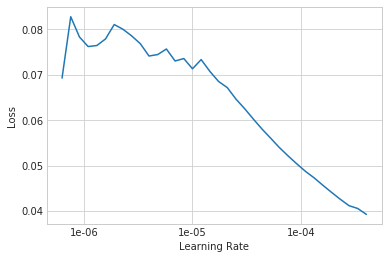

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best', mode='max')])

epoch,train_loss,valid_loss,accuracy,time
0,0.116852,0.388493,0.828571,00:01
1,0.079655,0.362379,0.857143,00:01
2,0.064075,0.329877,0.914286,00:01
3,0.050460,0.316867,0.914286,00:01
4,0.039266,0.318508,0.885714,00:01
5,0.031641,0.311961,0.885714,00:01
6,0.025718,0.318995,0.885714,00:01
7,0.021915,0.326763,0.885714,00:01
8,0.018676,0.325807,0.857143,00:01
9,0.018866,0.337859,0.857143,00:01


Better model found at epoch 0 with accuracy value: 0.8285714387893677.
Better model found at epoch 1 with accuracy value: 0.8571428656578064.
Better model found at epoch 2 with accuracy value: 0.9142857193946838.


In [31]:
learn.load('best');

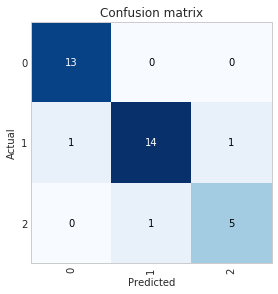

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()